# notebook with tasks for Capital One Data Science Challenge

### Executive Summary  - TO BE COMPLETED

Below are the code and answers to capital one's data science recruting challenge corresponding to the 4 areas of Load, Plot, Data Wrangling and Model

In [131]:
#import packages
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import datetime
import xgboost

import warnings
warnings.filterwarnings('ignore')

#to display all columns in dataframe
from IPython.display import display
pd.options.display.max_columns = None

%matplotlib inline

import data

In [2]:
trnz = pd.read_json(path_or_buf = "C://Users/campb/DS/transactions/transactions.txt", lines = True)

# Question 1: Load

- a) Please describe the structure of the data. Number of records and fields in each record?
- b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate.

answers a couple cells down after output is examined

In [3]:
trnz.shape

(786363, 29)

In [4]:
trnz.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,,0.0,,,,False,,,False,False
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,True,,,False,False
2,737265056,737265056,5000,5000.0,2016-11-08T09:18:39,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
3,737265056,737265056,5000,5000.0,2016-12-10T02:14:50,7.47,Play Store,US,US,09,01,mobileapps,08/2025,2015-03-14,2015-03-14,486,486,767,PURCHASE,,0.0,,,,False,,,False,False
4,830329091,830329091,5000,5000.0,2016-03-24T21:04:46,71.18,Tim Hortons #947751,US,US,02,01,fastfood,10/2029,2015-08-06,2015-08-06,885,885,3143,PURCHASE,,0.0,,,,True,,,False,False


In [5]:
trnz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786363 entries, 0 to 786362
Data columns (total 29 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   accountNumber             786363 non-null  int64  
 1   customerId                786363 non-null  int64  
 2   creditLimit               786363 non-null  int64  
 3   availableMoney            786363 non-null  float64
 4   transactionDateTime       786363 non-null  object 
 5   transactionAmount         786363 non-null  float64
 6   merchantName              786363 non-null  object 
 7   acqCountry                786363 non-null  object 
 8   merchantCountryCode       786363 non-null  object 
 9   posEntryMode              786363 non-null  object 
 10  posConditionCode          786363 non-null  object 
 11  merchantCategoryCode      786363 non-null  object 
 12  currentExpDate            786363 non-null  object 
 13  accountOpenDate           786363 non-null  o

In [6]:
trnz.describe(include = 'all')

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
count,7.863630e+05,7.863630e+05,786363.000000,786363.000000,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363.000000,786363.000000,786363.000000,786363,786363,786363.000000,786363,786363,786363,786363,786363,786363,786363,786363
unique,NaN,NaN,NaN,NaN,776637,NaN,2490,5,5,6,4,19,165,1820,2184,NaN,NaN,NaN,4,1,NaN,1,1,1,2,1,1,2,2
top,NaN,NaN,NaN,NaN,2016-05-28T14:24:41,NaN,Uber,US,US,05,01,online_retail,03/2029,2014-06-21,2016-03-15,NaN,NaN,NaN,PURCHASE,,NaN,,,,False,,,False,False
freq,NaN,NaN,NaN,NaN,4,NaN,25613,774709,778511,315035,628787,202156,5103,33623,3819,NaN,NaN,NaN,745193,786363,NaN,786363,786363,786363,433495,786363,786363,785320,773946
mean,5.372326e+08,5.372326e+08,10759.464459,6250.725369,NaN,136.985791,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,544.467338,544.183857,4757.417799,NaN,NaN,4508.739089,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2.554211e+08,2.554211e+08,11636.174890,8880.783989,NaN,147.725569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261.524220,261.551254,2996.583810,NaN,NaN,6457.442068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000881e+08,1.000881e+08,250.000000,-1005.630000,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.000000,0.000000,0.000000,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,3.301333e+08,3.301333e+08,5000.000000,1077.420000,NaN,33.650000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000000,310.000000,2178.000000,NaN,NaN,689.910000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,5.074561e+08,5.074561e+08,7500.000000,3184.860000,NaN,87.900000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,535.000000,535.000000,4733.000000,NaN,NaN,2451.760000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7.676200e+08,7.676200e+08,15000.000000,7500.000000,NaN,191.480000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,785.000000,785.000000,7338.000000,NaN,NaN,5291.095000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### - a) Please describe the structure of the data. Number of records and fields in each record?

- the number of records in total is 786,363 that span across 29 columns
- there are numeric, text and date columns throughout the dataset but the date columns have not been converted to dates
- there is a transactionDateTime column that is still stored as text after initial import that we'll need to convert to time, along with currentExpDate, accountOpenDate and dateOfLastAddressChange
- the info() function says that there are no nulls for all of the columns but the head() output shows blank values for the 1st 5 rows of echoBuffer, merchantState, merchantZip, merchantCity, posOnPremises, recurringAuthInd and the describe function shows that these columns are entirely blank because there's only 1 unique value and its a blank string so we can just drop these columns
- lets check to see if there are any string or numeric values that are actually blank

#### - b) Please provide some additional basic summary statistics for each field. Be sure to include a count of null, minimum, maximum, and unique values where appropriate. -> Seen in cell immediately above

- the numeric values have reasonable upper and lower limits: availableMoney has a negative value which, assuming this is something analogous to creditLimit - currentBalance, is possible that someone spent more than their creditLimit 
- the non-date string values dont have many unique values other than merchantName, 2,490, and merchantCategoryCode, 19, which we'd need to consolidate if we want to do logistic regression to prevent separability

In [7]:
#drop columns with all blanks
trnz2 = trnz.drop(['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'], axis = 1)

check if string variables are actually blanks

In [8]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

C:\Users\campb\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,781801,785639,782309,785954,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,786363.0,785665,786363.0,786363.0,786363.0,786363.0
True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4562,724,4054,409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,698,NaN,NaN,NaN,NaN


blanks in above string columns include
- 4,562 in acqCountry
- 724 in merchantCountryCode
- 4,054 in posEntryMode
- 409 in posConditionCode
- 698 in transactionType

In [9]:
trnz2.loc[ trnz2.acqCountry == ""].sample(30)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
360574,832842201,832842201,15000,5210.60,2016-01-18T17:41:29,428.33,Uber,,US,05,01,rideshare,12/2021,2015-02-21,2015-02-21,466,466,5266,PURCHASE,9789.40,False,False,False
444893,174140166,174140166,50000,37461.99,2016-08-10T04:23:42,16.91,hulu.com,,US,09,01,online_subscriptions,08/2026,2015-03-06,2016-01-17,162,162,6731,PURCHASE,12538.01,False,False,False
589498,882815134,882815134,50000,9672.95,2016-10-06T07:46:51,62.03,Renaissance Hotel #924524,,US,09,01,hotels,02/2032,2014-09-30,2016-09-29,959,959,8502,PURCHASE,40327.05,True,False,False
480607,478971361,478971361,7500,1322.05,2016-05-06T17:21:09,43.06,cheapfast.com,,US,05,01,online_retail,03/2028,2014-03-30,2016-03-27,275,275,3409,PURCHASE,6177.95,False,False,False
144419,802191006,802191006,5000,3181.99,2016-12-19T05:09:26,9.65,Washington Tire,,US,05,01,auto,02/2023,2015-02-15,2016-12-05,524,524,8586,PURCHASE,1818.01,True,False,False
563490,446530026,446530026,7500,3844.44,2016-08-16T13:11:25,108.48,Walgreens #561965,,,02,01,health,04/2029,2011-10-15,2016-04-13,483,483,9541,PURCHASE,3655.56,False,False,False
524673,912875484,912875484,250,51.34,2016-01-31T20:28:19,221.29,Fast Tire,,US,09,08,auto,12/2030,2015-09-12,2015-09-12,334,334,3072,PURCHASE,198.66,True,False,False
513156,793511392,793511392,15000,2462.41,2016-10-21T08:29:05,30.56,ebay.com,,US,80,01,online_retail,08/2021,2015-05-23,2016-06-26,989,989,7957,PURCHASE,12537.59,False,False,False
345599,842041530,842041530,10000,8857.54,2016-07-13T19:54:49,0.06,cheapfast.com,,US,05,08,online_retail,12/2023,2009-05-14,2016-01-04,304,304,3187,PURCHASE,1142.46,False,False,False
669575,527298269,527298269,15000,10443.11,2016-03-29T23:48:02,305.81,Eazy Auto Body,,US,05,01,auto,07/2032,2015-08-25,2016-02-10,214,214,987,PURCHASE,4556.89,True,False,False


these are actually all blank for acqCountry so we'll replace these values of empty strings with "blank"

In [10]:
trnz2['acqCountry'] = np.where(trnz2.acqCountry == "", "blank", trnz2.acqCountry)
trnz2['merchantCountryCode'] = np.where(trnz2.merchantCountryCode == "", "blank", trnz2.merchantCountryCode)
trnz2['posEntryMode'] = np.where(trnz2.posEntryMode == "", "blank", trnz2.posEntryMode)
trnz2['posConditionCode'] = np.where(trnz2.posConditionCode == "", "blank", trnz2.posConditionCode)
trnz2['transactionType'] = np.where(trnz2.transactionType == "", "blank", trnz2.transactionType)

confirm whether blanks still exist

In [11]:
trnz2.apply(lambda x: (x == "").value_counts(), axis = 0)

C:\Users\campb\anaconda3\lib\site-packages\pandas\core\ops\array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


no more blanks

nows lets try to see if there any numeric blanks

In [12]:
trnz2.apply(lambda x: (x == np.nan).value_counts(), axis = 0)

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud
False,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363,786363


lets plot the numeric variables to see if there are any odd values that look like they could be placeholders for blanks

C:\Users\campb\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  This is separate from the ipykernel package so we can avoid doing imports until


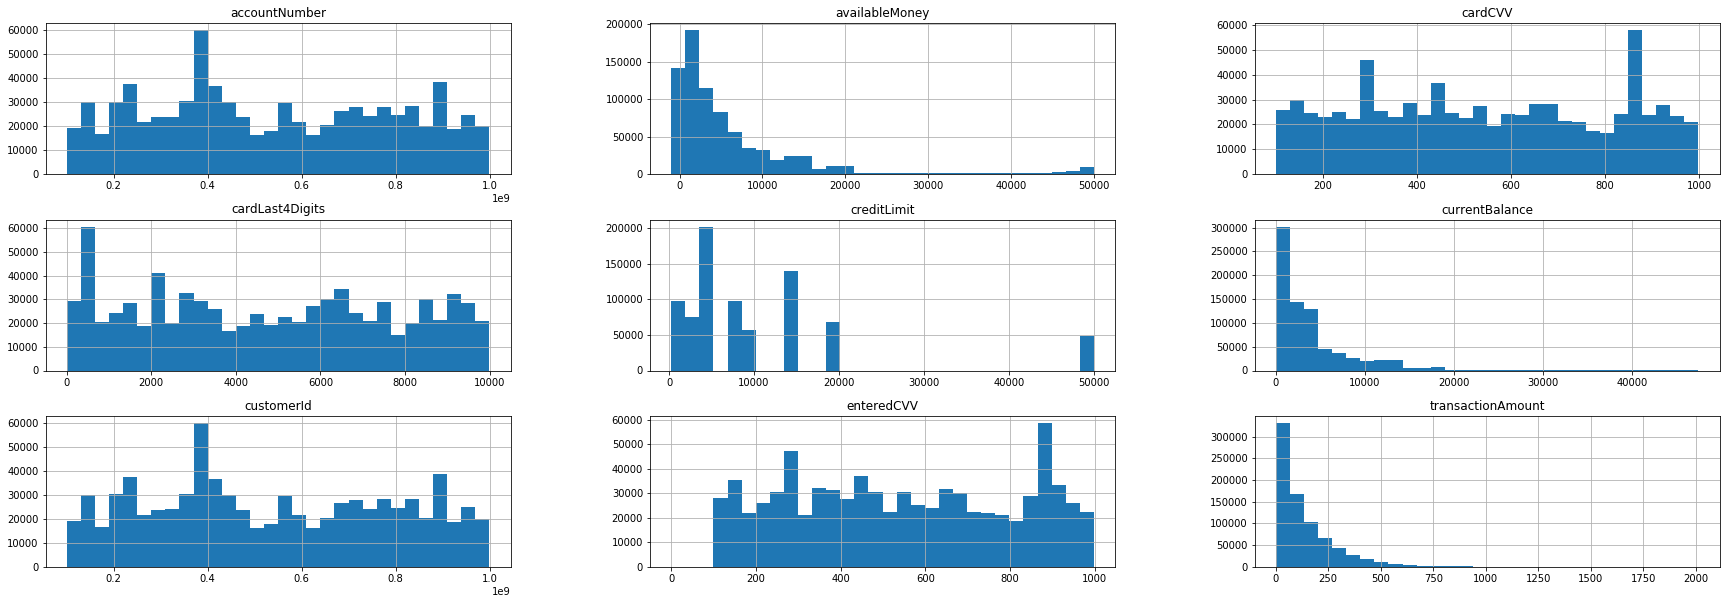

In [13]:
num_hist = plt.figure(figsize = (30, 10))
ax1 = num_hist.add_subplot(111)
trnz2.select_dtypes(include = ['int64', 'float64']).hist(ax = ax1, bins = 30);

- there are some numeric ranges that are markedly more popular like 4e8 in customerId and accountNumber but no values that are significantly farther away from the rest of the values like -9999 so we'll assume that none of the numeric values are blank

we'll convert the date columns to actual date values before moving forward
- transactionDateTime
- currentExpDate
- accountOpenDate
- dateOfLastAddressChange

In [14]:
trnz2[['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']].head()

,transactionDateTime,currentExpDate,accountOpenDate,dateOfLastAddressChange
0,2016-08-13T14:27:32,06/2023,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,02/2024,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,08/2025,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,08/2025,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,10/2029,2015-08-06,2015-08-06


In [15]:
trnz2['transactionDateTime_dt'] = pd.to_datetime(trnz2.transactionDateTime, format='%Y-%m-%dT%H:%M:%S')

In [16]:
trnz2['currentExpDate_dt'] = pd.to_datetime(trnz2.currentExpDate, format='%m/%Y')

In [17]:
trnz2['accountOpenDate_dt'] = pd.to_datetime(trnz2.accountOpenDate, format = '%Y-%m-%d')

In [18]:
trnz2['dateOfLastAddressChange_dt'] = pd.to_datetime(trnz2.dateOfLastAddressChange, format = '%Y-%m-%d')

confirm conversions are accurate

In [19]:
trnz2[['transactionDateTime', 'transactionDateTime_dt', 'currentExpDate', 'currentExpDate_dt', 'accountOpenDate', 'accountOpenDate_dt', 'dateOfLastAddressChange', 'dateOfLastAddressChange_dt']].head()

,transactionDateTime,transactionDateTime_dt,currentExpDate,currentExpDate_dt,accountOpenDate,accountOpenDate_dt,dateOfLastAddressChange,dateOfLastAddressChange_dt
0,2016-08-13T14:27:32,2016-08-13 14:27:32,06/2023,2023-06-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
1,2016-10-11T05:05:54,2016-10-11 05:05:54,02/2024,2024-02-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
2,2016-11-08T09:18:39,2016-11-08 09:18:39,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
3,2016-12-10T02:14:50,2016-12-10 02:14:50,08/2025,2025-08-01,2015-03-14,2015-03-14,2015-03-14,2015-03-14
4,2016-03-24T21:04:46,2016-03-24 21:04:46,10/2029,2029-10-01,2015-08-06,2015-08-06,2015-08-06,2015-08-06


yes, conversions look accurate, we'll proceed to question 2

# Question 2: Plot 

- Plot a histogram of the processed amounts of each transaction, the transactionAmount column.
- Report any structure you find and any hypotheses you have about that structure.

In [20]:
#get upper and lower limits of transactionAmount to inform binwidth
trnz2.transactionAmount.describe()

count    786363.000000
mean        136.985791
std         147.725569
min           0.000000
25%          33.650000
50%          87.900000
75%         191.480000
max        2011.540000
Name: transactionAmount, dtype: float64

In [21]:
2050/50

41.0

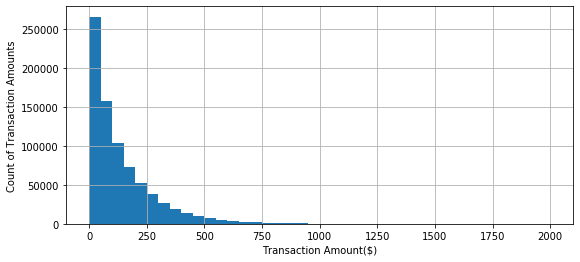

In [22]:
transplot = plt.figure(figsize = (20, 4))
ax1 = transplot.add_subplot(121)
trnz2.transactionAmount.hist(bins = range(0, 2050, 50), ax = ax1);
plt.xlabel('Transaction Amount($)');
plt.ylabel('Count of Transaction Amounts');

- the histogram of the transaction amount is largely right-skewed with a long right tail, largely following a log distribution
- most of the density is for transaction amounts less than 500, which leads me to hypothesize that most of these transactions are for everyday consumer products, entertainment, travel and billpay transactions as opposed to larger transactions like rent and loan payments
- it is odd that there are transactions with a value of 0 -> could that be something that isnt actually a purchase but still counts as a "transaction"?
- because of this distribution's shape, it should transform to a relatively normal distribution if we apply the log transformation, which could help in specifying variables in our model if we use a logistic regression model
- another thing to note is that, because we'll be using this data to build a fraud model and most transactions seem like everyday purchases in that they're under \\$500, maybe the transactions over a certain dollar value, e.g. \\$1000, are more likely to be fraudulent

In [23]:
trnz2['transactionAmount_log'] = trnz2.transactionAmount.apply(lambda x: np.log(x+0.01)) #have to shift by small constant bc 0 is undefined for the log distribution

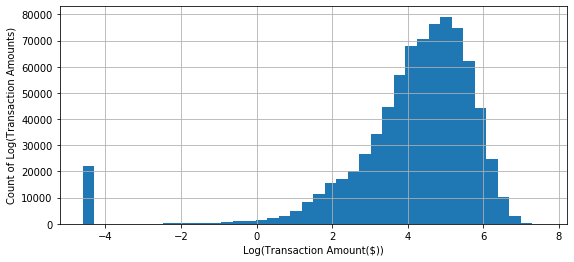

In [24]:
transplot2 = plt.figure(figsize = (20, 4))
ax1 = transplot2.add_subplot(121)
trnz2.transactionAmount_log.hist(bins = 40, ax = ax1);
plt.xlabel('Log(Transaction Amount($))');
plt.ylabel('Count of Log(Transaction Amounts)');

In [25]:
np.log(0.01)

-4.605170185988091

- the log transformed transaction amount is not quite normal and has a density below -4 corresponding to the shifted value of 0

# Question 3: Data Wrangling

- reversed transaction, where a purchase is followed by a reversal
- multi-swipe, where a vendor accidentally charges a customer's card multiple times within a short time span

- Can you programmatically identify reversed and multi-swipe transactions?
- What total number of transactions and total dollar amount do you estimate for the reversed transactions? For the multi-swipe transactions? (please consider the first transaction to be "normal" and exclude it from the number of transaction and dollar amount counts)
- Did you find anything interesting about either kind of transaction?

In [26]:
trnz2.head(2) #get column names to use in reversal and multiswipe transactions

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log
0,737265056,737265056,5000,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,01,rideshare,06/2023,2015-03-14,2015-03-14,414,414,1803,PURCHASE,0.0,False,False,False,2016-08-13 14:27:32,2023-06-01,2015-03-14,2015-03-14,4.590665
1,737265056,737265056,5000,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,01,entertainment,02/2024,2015-03-14,2015-03-14,486,486,767,PURCHASE,0.0,True,False,False,2016-10-11 05:05:54,2024-02-01,2015-03-14,2015-03-14,4.311068


In [27]:
#what is in transactionType?
trnz2.transactionType.unique()

array(['PURCHASE', 'ADDRESS_VERIFICATION', 'REVERSAL', 'blank'],
      dtype=object)

reversal is already listed but multiswipe is not

In [28]:
# identify reversed and multiswipe transactions by sort dataset by account, customer, card, puchasetime
# if next transactionAmount is the same as the previous and from the same merchant that would mean a reversal 
# if the next transaction(s) have the same amount as the previous and is from the same merchant that would identify multi-swipe

trnz3 = trnz2.sort_values(by = ['accountNumber', 'customerId', 'cardLast4Digits', 'transactionDateTime_dt'], ascending = True).reset_index(drop = True)

In [29]:
#check range of transactionDateTime to pick value to impute nulls with
trnz3.transactionDateTime_dt.describe()

count                  786363
unique                 776637
top       2016-12-25 14:04:15
freq                        4
first     2016-01-01 00:01:02
last      2016-12-30 23:59:45
Name: transactionDateTime_dt, dtype: object

In [30]:
trnz3['accountNumber_shift'] = trnz3.accountNumber.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['customerId_shift'] = trnz3.customerId.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['cardLast4Digits_shift'] = trnz3.cardLast4Digits.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionDateTime_dt_shift'] = trnz3.transactionDateTime_dt.shift(periods = 1, axis = 'rows', fill_value = pd.to_datetime('2000-01-01 00:00:00', format = '%Y-%m-%d %H:%M:%S'))
trnz3['transactionAmount_shift'] = trnz3.transactionAmount.shift(periods = 1, axis = 'rows', fill_value = -99)
trnz3['transactionType_shift'] = trnz3.transactionType.shift(periods = 1, axis = 'rows', fill_value = 'blank')
trnz3['merchantName_shift'] = trnz3.merchantName.shift(periods = 1, axis = 'rows', fill_value = 'blank')

In [31]:
def find_duplicates(row):
    if (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'REVERSAL') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'reversed'
    elif (row['accountNumber'] == row['accountNumber_shift']) & (row['customerId'] == row['customerId_shift']) &\
        (row['cardLast4Digits'] == row['cardLast4Digits_shift']) &\
        (row['transactionDateTime_dt'] <= (row['transactionDateTime_dt_shift'] + datetime.timedelta(hours = 24))) &\
        (row['transactionType'] == 'PURCHASE') & (row['transactionType_shift'] == 'PURCHASE') &\
        (row['transactionAmount'] == row['transactionAmount_shift']) & (row['merchantName'] == row['merchantName_shift']):
        return 'multi_swipe'
    else:
        return 'non_duplicate'

In [32]:
trnz3['duplicateType'] = trnz3.apply(find_duplicates, axis = 1)

In [33]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

check some transactions

In [34]:
trnz3.loc[trnz3.duplicateType == 'reversed', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
219052,4571,31.76
740227,6698,85.33
670504,4487,411.34
619421,1241,58.39
247003,593,224.53


In [35]:
trnz3.loc[ (trnz3.cardLast4Digits == 9395) & (trnz3.transactionAmount == 9.68)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
632497,810471359,810471359,5000,1443.23,2016-01-15T13:46:32,9.68,apple.com,US,US,09,08,online_retail,11/2028,2015-11-03,2015-11-03,713,713,9395,PURCHASE,3556.77,False,False,False,2016-01-15 13:46:32,2028-11-01,2015-11-03,2015-11-03,2.271094,810471359,810471359,9395,2016-01-15 06:48:23,184.26,REVERSAL,discount.com,non_duplicate
632498,810471359,810471359,5000,1433.55,2016-01-15T13:48:44,9.68,apple.com,US,US,09,08,online_retail,11/2028,2015-11-03,2015-11-03,713,713,9395,REVERSAL,3566.45,False,False,False,2016-01-15 13:48:44,2028-11-01,2015-11-03,2015-11-03,2.271094,810471359,810471359,9395,2016-01-15 13:46:32,9.68,PURCHASE,apple.com,reversed


In [36]:
trnz3.loc[ (trnz3.cardLast4Digits == 4609) & (trnz3.transactionAmount == 62.52)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
33901,142263758,142263758,2500,1294.95,2016-10-17T01:15:42,62.52,Next Day eCards,US,US,05,01,online_gifts,07/2030,2013-09-19,2016-02-03,522,522,4609,PURCHASE,1205.05,False,False,False,2016-10-17 01:15:42,2030-07-01,2013-09-19,2016-02-03,4.135646,142263758,142263758,4609,2016-10-16 21:00:34,155.63,PURCHASE,williamssonoma.com,non_duplicate
33902,142263758,142263758,2500,1232.43,2016-10-17T01:17:07,62.52,Next Day eCards,US,US,05,01,online_gifts,07/2030,2013-09-19,2016-02-03,522,522,4609,REVERSAL,1267.57,False,False,False,2016-10-17 01:17:07,2030-07-01,2013-09-19,2016-02-03,4.135646,142263758,142263758,4609,2016-10-17 01:15:42,62.52,PURCHASE,Next Day eCards,reversed


In [37]:
trnz3.loc[ (trnz3.cardLast4Digits == 4165) & (trnz3.transactionAmount == 232.20)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
758045,957964653,957964653,15000,11791.95,2016-10-04T18:42:28,232.2,walmart.com,US,US,05,01,online_retail,12/2026,2015-10-12,2015-10-12,784,784,4165,PURCHASE,3208.05,False,False,False,2016-10-04 18:42:28,2026-12-01,2015-10-12,2015-10-12,5.447642,957964653,957964653,4165,2016-09-23 23:45:48,58.97,PURCHASE,Sunoco Gas #316345,non_duplicate
758046,957964653,957964653,15000,11559.75,2016-10-04T18:43:58,232.2,walmart.com,US,US,05,01,online_retail,12/2026,2015-10-12,2015-10-12,784,784,4165,REVERSAL,3440.25,False,False,False,2016-10-04 18:43:58,2026-12-01,2015-10-12,2015-10-12,5.447642,957964653,957964653,4165,2016-10-04 18:42:28,232.20,PURCHASE,walmart.com,reversed


reversed transactions look right so now lets check multi_swipe

In [38]:
trnz3.loc[trnz3.duplicateType == 'multi_swipe', ['cardLast4Digits', 'transactionAmount']].sample(5)

,cardLast4Digits,transactionAmount
657817,4335,173.70
487603,5718,334.96
82954,9967,36.90
66143,4544,20.95
768824,1545,392.54


In [39]:
trnz3.loc[ (trnz3.cardLast4Digits == 9685) & (trnz3.transactionAmount == 113.57)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
208151,346419123,346419123,7500,7500.00,2016-02-01T21:54:38,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,0.00,True,False,False,2016-02-01 21:54:38,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-01-31 17:26:20,3.56,REVERSAL,discount.com,non_duplicate
208152,346419123,346419123,7500,7386.43,2016-02-01T21:57:16,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,113.57,True,False,False,2016-02-01 21:57:16,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-02-01 21:54:38,113.57,PURCHASE,Starbucks #516830,multi_swipe
208153,346419123,346419123,7500,7272.86,2016-02-01T21:58:18,113.57,Starbucks #516830,US,US,02,01,fastfood,06/2026,2015-04-14,2015-04-14,149,149,9685,PURCHASE,227.14,True,False,False,2016-02-01 21:58:18,2026-06-01,2015-04-14,2015-04-14,4.732507,346419123,346419123,9685,2016-02-01 21:57:16,113.57,PURCHASE,Starbucks #516830,multi_swipe


In [40]:
trnz3.loc[ (trnz3.cardLast4Digits == 9102) & (trnz3.transactionAmount == 151.64)] #looks right - same amount, same merchant, seconds from each other

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType
714068,894938833,894938833,15000,2371.86,2016-12-12T11:00:25,151.64,Walgreens #808671,US,US,09,01,health,06/2020,2014-11-05,2016-11-13,689,689,9102,PURCHASE,12628.14,True,False,False,2016-12-12 11:00:25,2020-06-01,2014-11-05,2016-11-13,5.021575,894938833,894938833,9102,2016-12-12 10:38:19,377.18,PURCHASE,NYSC #331326,non_duplicate
714069,894938833,894938833,15000,2220.22,2016-12-12T11:01:18,151.64,Walgreens #808671,US,US,09,01,health,06/2020,2014-11-05,2016-11-13,689,689,9102,PURCHASE,12779.78,True,False,False,2016-12-12 11:01:18,2020-06-01,2014-11-05,2016-11-13,5.021575,894938833,894938833,9102,2016-12-12 11:00:25,151.64,PURCHASE,Walgreens #808671,multi_swipe


### estimated total number of reversed and multi-swipe transactions

In [41]:
trnz3.duplicateType.value_counts(dropna = False)

non_duplicate    773519
multi_swipe        7342
reversed           5502
Name: duplicateType, dtype: int64

### estimated dollar amounts for reversed and multi_swipe transactions

In [42]:
trnz3.groupby('duplicateType')['transactionAmount'].sum().apply(lambda x: '${:,.2f}'.format(x))

duplicateType
multi_swipe        $1,087,165.85
non_duplicate    $105,808,565.16
reversed             $824,826.52
Name: transactionAmount, dtype: object

### over \\$820K in reversed transactions and \\$1.08M for multi swipe transactions

is there anything interesting about the reversed and multi-swipe transactions relative to the non-duplicate transactions?
- transactionAmount?
- particular merchant categories?
- particular days?
- merchant locations?

duplicateType x transactionAmount

In [57]:
trnz3.groupby('duplicateType')['transactionAmount'].describe()

,count,mean,std,min,25%,50%,75%,max
duplicateType,,,,,,,,
multi_swipe,7342.0,148.074891,147.997143,0.01,41.5725,101.265,205.810,1394.19
non_duplicate,773519.0,136.788579,147.675165,0.00,33.5400,87.650,191.230,2011.54
reversed,5502.0,149.913944,153.233509,0.09,41.0700,104.305,204.295,1338.25


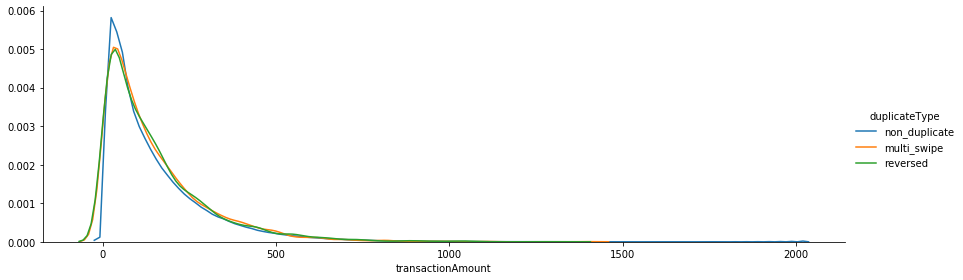

In [58]:
dup_amt = sns.FacetGrid(data = trnz3, hue = 'duplicateType', sharex = True, sharey = False, height = 4, aspect = 3)
dup_amt = dup_amt.map(sns.kdeplot, 'transactionAmount').add_legend();

- mean transaction amounts for reversed and multi_swipe transactions are a little higher but this doesnt look to be a significant difference and not one that we would expect -> we could do a formal non-parametric kruskall wallis test but that seems unnecessary here because we're just doing some exploration

merchant types

In [68]:
merchCatlist = list(trnz3.merchantCategoryCode.unique())
merchCatlist.sort()

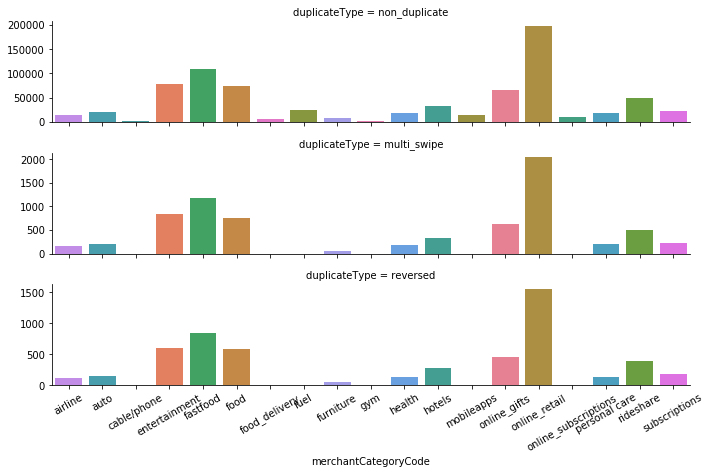

In [75]:
dup_merch = sns.FacetGrid(data = trnz3, row = 'duplicateType', hue = 'merchantCategoryCode', sharey = False, height = 2, aspect = 5)
dup_merch = dup_merch.map(sns.countplot, 'merchantCategoryCode', orient = "v", order = merchCatlist);
plt.xticks(rotation = 30);

there dont appear to be any patterns of duplicate or multi-swipe transactions occurring more often at particular kinds of merchants

lets check days or hours of the day for patterns of more duplicate transactions, i.e. at the end of the week or day are reversed or multi_swipe transactions more prevalent?

In [193]:
wkday_dict = {0:'Mon', 1:'Tues', 2:'Weds', 3:'Thurs', 4:'Fri', 5:'Sat', 6:'Sun'}
trnz3['trns_weekday'] = pd.Categorical(trnz3.transactionDateTime_dt.dt.date.apply(lambda x: x.weekday()).map(wkday_dict), 
                                       categories = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun'], ordered = True)
trnz3['trns_hr'] = trnz3.transactionDateTime_dt.dt.hour

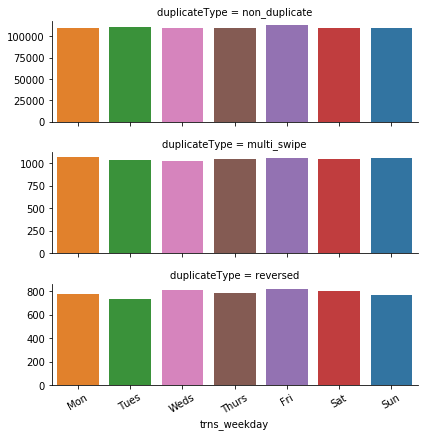

In [84]:
dup_day = sns.FacetGrid(data = trnz3, row = 'duplicateType', hue = 'trns_weekday', sharey = False, height = 2, aspect = 3)
dup_day = dup_day.map(sns.countplot, 'trns_weekday', orient = "v", order = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']);
plt.xticks(rotation = 30);

duplicate transactions dont have any pattern across weekdays either as they are uniformly distributed across days of the week for each transaction type

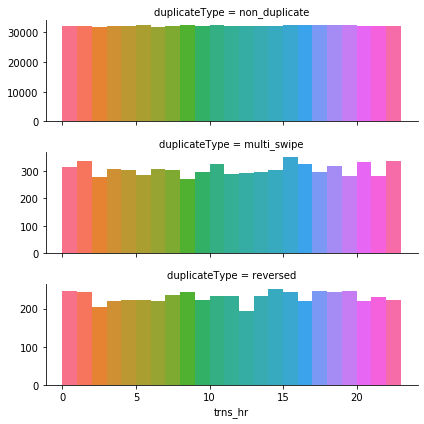

In [87]:
dup_hr = sns.FacetGrid(data = trnz3, row = 'duplicateType', hue = 'trns_hr', sharey = False, height = 2, aspect = 3)
dup_hr = dup_hr.map(plt.hist, 'trns_hr', bins = range(0, 24, 1));

- there is not a pattern of reversed or multi swipe transactions across hours of the day either

merchant geographies

In [106]:
dup_geo_df = trnz3.groupby(['duplicateType', 'merchantCountryCode']).size().reset_index()
dup_geo_df.columns = ['duplicateType', 'merchantCountryCode', 'transactions']

In [114]:
dup_geo_total = trnz3.groupby('duplicateType').size().reset_index()
dup_geo_total.columns = ['duplicateType', 'totalTransactions']

In [115]:
dup_geo_df2 = dup_geo_df.merge(dup_geo_total, on = 'duplicateType', how = 'inner')

In [121]:
dup_geo_df2['country_pct_transactions'] = np.round(dup_geo_df2.transactions / dup_geo_df2.totalTransactions, 3)

In [122]:
dup_geo_df2

,duplicateType,merchantCountryCode,transactions,totalTransactions,country_pct_transactions
0,multi_swipe,CAN,20,7342,0.003
1,multi_swipe,MEX,30,7342,0.004
2,multi_swipe,PR,11,7342,0.001
3,multi_swipe,US,7280,7342,0.992
4,multi_swipe,blank,1,7342,0.000
5,non_duplicate,CAN,2381,773519,0.003
6,non_duplicate,MEX,3083,773519,0.004
7,non_duplicate,PR,1537,773519,0.002
8,non_duplicate,US,765799,773519,0.990
9,non_duplicate,blank,719,773519,0.001


- there doesnt appear to be a notable relationship between merchantCountry and duplicate transactions either
- therefore, if there is an interesting relationship with duplicate transaction types we'd have to do more research to find it

# Question 4: Model

- Each of the transactions in the dataset has a field called isFraud. Please build a predictive model to determine whether a given transaction will be fraudulent or not. Use as much of the data as you like (or all of it).
- Provide an estimate of performance using an appropriate sample, and show your work.
- Please explain your methodology (modeling algorithm/method used and why, what features/data you found useful, what questions you have, and what you would do next with more time)

Approach: assuming that this is a predictive model whose predictive performance outweighs interpreting coefficients to make recommendations related to variables in the model, particularly because fraud is the use-case, we'll fit a couple models to compare their performance
1. separate into training and test set - training to build the model and test to compare out-of-sample predictive performance
2. make some derived variables
3. perform some exploratory data analysis on explanatory variables as well as their relationship with the response
4. fit a couple models with different explanatory variable representations
    - regularized logistic regression for linear parameterization of explanatory variables
    - gradient boosted tree for tree structure
    - naive bayes for bayesian parameterization
5. score models on test set and compare performance

#### 1. train and test split - 85/15 assuming that fraud will be a rare event to have enough cases in the training set to build model and relatively small test set

In [92]:
trnz3['ran_num'] = np.random.uniform(low = 0, high = 1, size = trnz3.shape[0])
trnz3['train_test'] = np.where(trnz3.ran_num >= 0.15, 'train', 'test')

In [196]:
trn = trnz3.loc[ trnz3.train_test == 'train']

In [94]:
#proportion of fraudulent cases in training set
np.round(trn.isFraud.value_counts(dropna = False) / trn.shape[0], 3)

False    0.984
True     0.016
Name: isFraud, dtype: float64

1.6% of rows is fraudulent in the training set

#### 2. make some derived variables

In [95]:
trn.head()

,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,posConditionCode,merchantCategoryCode,currentExpDate,accountOpenDate,dateOfLastAddressChange,cardCVV,enteredCVV,cardLast4Digits,transactionType,currentBalance,cardPresent,expirationDateKeyInMatch,isFraud,transactionDateTime_dt,currentExpDate_dt,accountOpenDate_dt,dateOfLastAddressChange_dt,transactionAmount_log,accountNumber_shift,customerId_shift,cardLast4Digits_shift,transactionDateTime_dt_shift,transactionAmount_shift,transactionType_shift,merchantName_shift,duplicateType,trns_weekday,trns_hr,ran_num,train_test
0,100088067,100088067,50000,49748.44,2016-01-17T15:41:46,378.67,Mobile eCards,US,US,05,01,online_gifts,11/2031,2014-01-09,2014-01-09,402,402,2077,PURCHASE,251.56,False,False,False,2016-01-17 15:41:46,2031-11-01,2014-01-09,2014-01-09,5.936692,-99,-99,-99,2000-01-01 00:00:00,-99.00,blank,blank,non_duplicate,Sun,15,0.503363,train
1,100088067,100088067,50000,49792.33,2016-02-08T06:09:12,259.44,Blue Mountain eCards,US,US,05,01,online_gifts,01/2028,2014-01-09,2014-01-09,402,402,2077,PURCHASE,207.67,False,False,False,2016-02-08 06:09:12,2028-01-01,2014-01-09,2014-01-09,5.558564,100088067,100088067,2077,2016-01-17 15:41:46,378.67,PURCHASE,Mobile eCards,non_duplicate,Mon,6,0.720284,train
2,100088067,100088067,50000,49532.89,2016-02-09T18:36:53,32.50,EZ Putt Putt #804489,US,US,09,01,entertainment,07/2026,2014-01-09,2014-01-09,402,402,2077,PURCHASE,467.11,True,False,False,2016-02-09 18:36:53,2026-07-01,2014-01-09,2014-01-09,3.481548,100088067,100088067,2077,2016-02-08 06:09:12,259.44,PURCHASE,Blue Mountain eCards,non_duplicate,Tues,18,0.449450,train
3,100088067,100088067,50000,49477.33,2016-02-13T20:17:41,56.05,Fresh Flowers,US,US,05,01,online_gifts,01/2033,2014-01-09,2014-01-09,402,402,2077,PURCHASE,522.67,False,False,False,2016-02-13 20:17:41,2033-01-01,2014-01-09,2014-01-09,4.026423,100088067,100088067,2077,2016-02-09 18:36:53,32.50,PURCHASE,EZ Putt Putt #804489,non_duplicate,Sat,20,0.960284,train
4,100088067,100088067,50000,49923.92,2016-03-12T12:55:28,97.79,Dinosaur Sandwitch Bar #960325,US,US,05,01,food,01/2032,2014-01-09,2014-01-09,402,402,2077,PURCHASE,76.08,True,False,False,2016-03-12 12:55:28,2032-01-01,2014-01-09,2014-01-09,4.582925,100088067,100088067,2077,2016-02-13 20:17:41,56.05,PURCHASE,Fresh Flowers,non_duplicate,Sat,12,0.903205,train


what do the values in acqCountry and merchantCountyCode look like?

In [97]:
trn.acqCountry.value_counts(dropna = False)

US       658249
blank      3894
MEX        2657
CAN        2077
PR         1300
Name: acqCountry, dtype: int64

In [98]:
trn.merchantCountryCode.value_counts(dropna = False)

US       661490
MEX        2665
CAN        2080
PR         1319
blank       623
Name: merchantCountryCode, dtype: int64

- % creditUtilization = cardBalance / creditLimit
- acq country = merchant country
- time since account open
- time since last address change (potentially last time account information was updated, potentially including security settings like password making fraud harder)
- cardCVV = enteredCVV
- transaction month

In [126]:
trn.transactionDateTime_dt.head().apply(lambda x: x.month)

0    1
1    2
2    2
3    2
4    3
Name: transactionDateTime_dt, dtype: int64

In [197]:
trn['creditUtil'] = trn.currentBalance / trn.creditLimit
trn['acqEqMerchCountry'] = np.where(trn.acqCountry == trn.merchantCountryCode, 'Yes', 'No')
trn['daysSinceAcctOpen'] = (trn.transactionDateTime_dt.dt.date - trn.accountOpenDate_dt.dt.date).dt.days
trn['daysSinceAddressChange'] = (trn.transactionDateTime_dt.dt.date - trn.dateOfLastAddressChange_dt.dt.date).dt.days
trn['cvvEqual'] = np.where(trn.cardCVV == trn.enteredCVV, 'Yes' ,'No')

#map months to categories so categorical representation is used instead of continuous in the model
month_dict = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
trn['transactionMonth'] = pd.Categorical(trn.transactionDateTime_dt.apply(lambda x: x.month).map(month_dict),
                                         categories = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], ordered = True)

#### 3. do some exploratory data analysis on individual variables and derived variables vs the response variable

In [133]:
trn.isFraud.unique()

array([False,  True])

In [198]:
# create response variable for model
trn['fraud'] = np.where(trn.isFraud == True, 1, 0)

continuous variables first

In [175]:
trn.select_dtypes(include = ['int64', 'float64']).columns

Index(['accountNumber', 'customerId', 'creditLimit', 'availableMoney',
       'transactionAmount', 'cardCVV', 'enteredCVV', 'cardLast4Digits',
       'currentBalance', 'transactionAmount_log', 'accountNumber_shift',
       'customerId_shift', 'cardLast4Digits_shift', 'transactionAmount_shift',
       'trns_hr', 'ran_num', 'creditUtil', 'daysSinceAcctOpen',
       'daysSinceAddressChange'],
      dtype='object')

In [161]:
cont_desc_df = trn.groupby('isFraud')['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange'].describe().stack().reset_index()
cont_desc_df.columns = ['isFraud', 'stat', 'creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange']
cont_desc_df.sort_values(by = ['stat', 'isFraud'])

,isFraud,stat,creditLimit,availableMoney,transactionAmount,currentBalance,transactionAmount_log,trns_hr,creditUtil,daysSinceAcctOpen,daysSinceAddressChange
4,False,25%,5000.000000,1078.680000,33.200000,688.302500,3.502851,6.000000,0.172239,430.000000,29.000000
12,True,25%,5000.000000,1078.985000,85.235000,841.895000,4.445529,6.000000,0.197366,427.000000,23.000000
5,False,50%,7500.000000,3192.400000,86.720000,2448.810000,4.462800,12.000000,0.472648,680.000000,160.000000
13,True,50%,7500.000000,3118.600000,176.180000,2751.540000,5.171563,12.000000,0.498000,665.000000,127.000000
6,False,75%,15000.000000,7500.000000,189.210000,5290.935000,5.242910,18.000000,0.731010,1111.000000,613.000000
14,True,75%,15000.000000,7500.000000,310.255000,5644.540000,5.737427,17.000000,0.747113,1007.000000,554.000000
0,False,count,657550.000000,657550.000000,657550.000000,657550.000000,657550.000000,657550.000000,657550.000000,657550.000000,657550.000000
8,True,count,10627.000000,10627.000000,10627.000000,10627.000000,10627.000000,10627.000000,10627.000000,10627.000000,10627.000000
7,False,max,50000.000000,50000.000000,2011.540000,47498.810000,7.606661,23.000000,4.722200,9990.000000,9990.000000
15,True,max,50000.000000,50000.000000,1608.350000,47473.940000,7.382970,23.000000,3.457560,9890.000000,9890.000000


- mean transaction amounts are higher for fraud, but maximum is lower and standard deviation is higher -> interesting
- days since account open is slightly less the fraud transactions
- some difference between means in daysSinceAddressChange
- other variables variables dont reveal much difference in distribution between fraudulent transactions and not

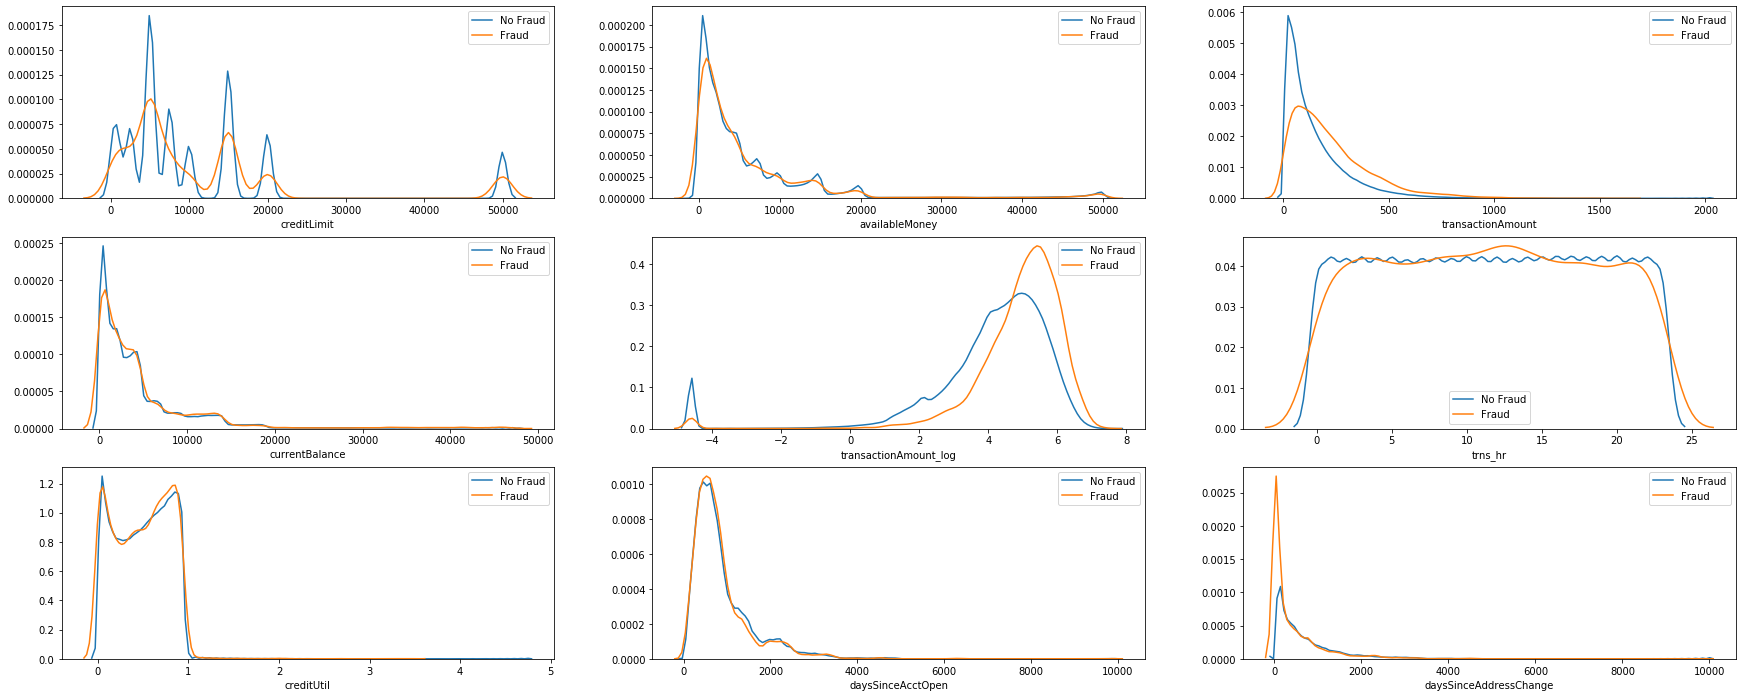

In [199]:
#continuous variables vs isFraud - 
cont_vars = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance', 'transactionAmount_log', 
    'trns_hr', 'creditUtil', 'daysSinceAcctOpen', 'daysSinceAddressChange']

cont_fig = plt.figure(figsize = (30, 12))

for c in cont_vars:

    ax = cont_fig.add_subplot(3,3,(cont_vars.index(c) + 1))
    sns.distplot(trn.loc[ trn.fraud == 0, c], label = 'No Fraud', hist = False)
    sns.distplot(trn.loc[ trn.fraud == 1, c], label = 'Fraud', hist = False)
    plt.legend();

- similar to the summary statistics we saw above, transactionAmount and transactionAmoung_log show some differences in their distribution
- another variable whose distribution is slightly different by fraud/no fraud is trns_hr (hour of transaction), which shows slightly more central tendency for fraudulent transactions than non-fraudulent around hour 12-13 whereas non-fraudulent transactions have a virtually uniform distribution
- we'll see whether these variables are helpful or not

categorical variables versus fraud

In [178]:
trn.select_dtypes(include = ['O']).columns

Index(['transactionDateTime', 'merchantName', 'acqCountry',
       'merchantCountryCode', 'posEntryMode', 'posConditionCode',
       'merchantCategoryCode', 'currentExpDate', 'accountOpenDate',
       'dateOfLastAddressChange', 'transactionType', 'transactionType_shift',
       'merchantName_shift', 'duplicateType', 'trns_weekday', 'train_test',
       'acqEqMerchCountry', 'cvvEqual', 'transactionMonth'],
      dtype='object')

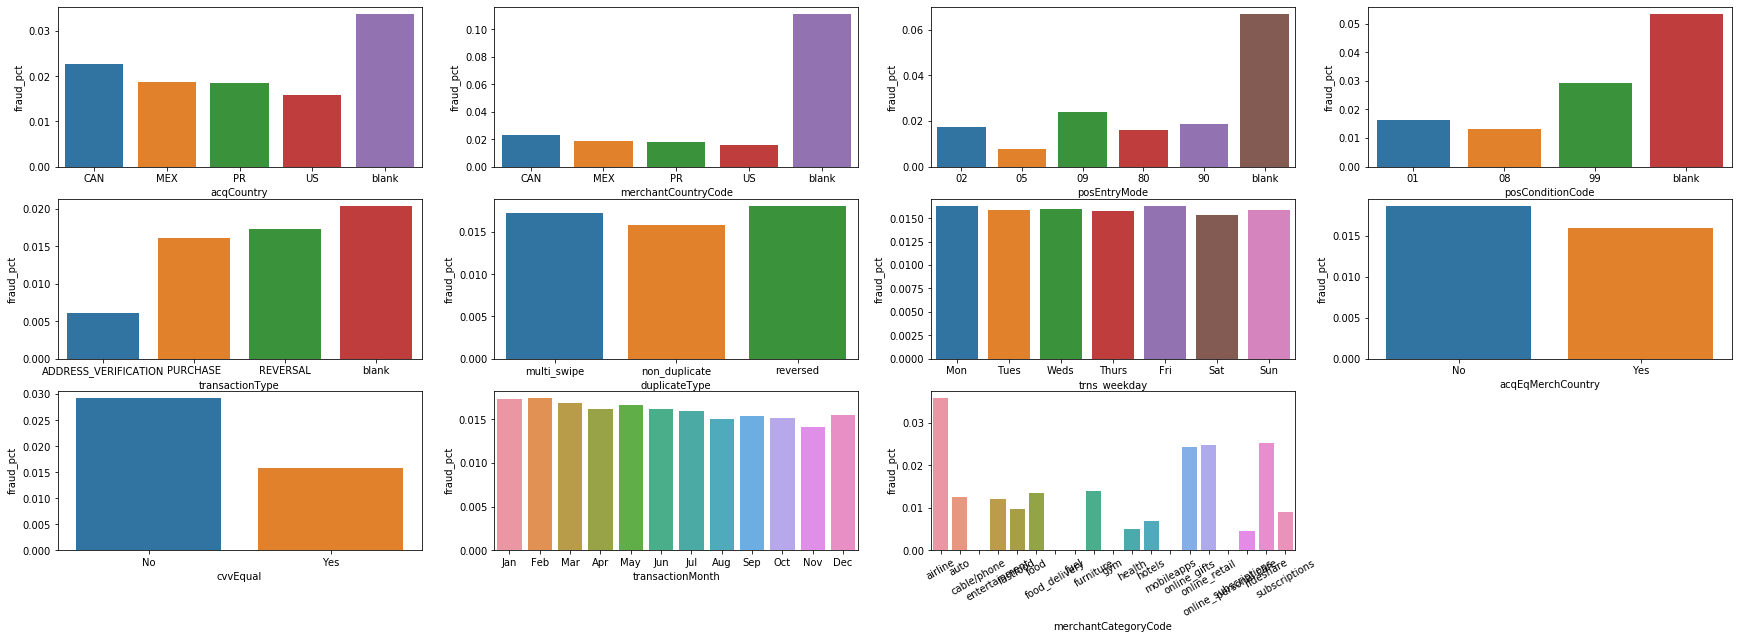

In [200]:
cat_vars = ['acqCountry', 'merchantCountryCode', 'posEntryMode', 'posConditionCode', 'transactionType', 'duplicateType', 
            'trns_weekday', 'acqEqMerchCountry', 'cvvEqual', 'transactionMonth', 'merchantCategoryCode']

cat_fig = plt.figure(figsize = (30, 10))

for c in cat_vars:
    
    test_df = pd.crosstab(trn[c], trn.fraud).reset_index()
    test_df.columns = [c, 'nofraud', 'fraud']
    test_df['fraud_pct'] =  test_df.fraud / (test_df.fraud + test_df.nofraud)
    
    if c == 'merchantCategoryCode':
    
        ax = cat_fig.add_subplot(3,4,(cat_vars.index(c)+1))
        sns.barplot(data = test_df, x = c, y = 'fraud_pct');
        plt.xticks(rotation = 30);
        
    else:
        
        ax = cat_fig.add_subplot(3,4,(cat_vars.index(c)+1))
        sns.barplot(data = test_df, x = c, y = 'fraud_pct');

- plenty of interesting differences among categorical variables
- blank values have a notably (maybe significant, maybe not) higher percentage fraudulent transactions including within acqCountry, merchantCountryCode, posEntryMode, posConditionCode and transactionType, which isn't entirely surprising
- instances where the acquisition country doesnt equal the merchant country have a slightly higher percentage of fraudulent transactions
- instances where the cvv isnt equal has a likelihood of being fraudulent twice as much as not fraudulent
- airlines, mobileapps, online_gifts and rideshare have notably higher percentages of fraudulent transactions as well
- day of week, month and duplicate type dont appear to have notable differences in percentage of fraudulent transactions

#### 4. model fitting